# Projet SER

### Audio Features
Features are things that can be quantified using numbers and should be observable in all the data points. For example a feature of a house would be number of bedrooms, price of the house, area of the house, age of the house etc. 
Every music file is basically made up of two important things, the sample rate, and the sample data. Now with the help of the sample rate and the sample data, one can perform several transformations on it to extract valuable features out of it.

`Zero Cross Rate, Energy, Entropy of Energy, Spectral Centroid, Spectral Spread, Spectral Entropy, Spectral Flux, Spectral Roll off, MFCC, Chroma Vector, Chroma Deviation`

A detailed article on audio features : https://medium.com/heuristics/audio-signal-feature-extraction-and-clustering-935319d2225

`Zero Crossing Rate (ZCR)`: Measures the rate at which the signal changes sign. It can be relevant for percussive sounds and might capture certain aspects of emotion expression.

`Energy`: Represents the energy content of the audio signal. It can provide information about the intensity of the sound, which may be correlated with emotional expressiveness.

`Entropy of Energy`: Captures the variability or disorder in the energy distribution. It can offer insights into the complexity of the audio signal.

`Spectral Centroid`: Indicates the center of mass of the spectrum. It can provide information about the "brightness" of the sound and may be relevant for certain emotions.

`Spectral Spread`: Describes the width of the spectrum. It might capture the range of frequencies present in the signal, which could be relevant for emotional content.

`Spectral Entropy`: Measures the amount of uncertainty or disorder in the spectrum. It can be useful for capturing the diversity of frequency components.

`Spectral Flux`: Represents the change in spectral content over time. It can be indicative of dynamic changes in the audio signal and may be relevant for emotional transitions.

`Spectral Roll-off`: Denotes the frequency below which a certain percentage of the total spectral energy is contained. It can provide information about the dominant frequency content.

`Mel-Frequency Cepstral Coefficients (MFCC)`: Captures the spectral characteristics of the sound in a way that is perceptually relevant. They are widely used in speech and audio processing tasks.

`Chroma Vector`: Represents the distribution of pitch classes in the audio signal. It can be useful for capturing tonal characteristics and musical aspects of emotion.

`Chroma Deviation`: Measures the deviation of the chroma vector from the expected distribution. It can provide insights into the tonal stability of the audio.


In [1]:
import os
import numpy as np
import pandas as pd
import joblib
import json
import kaggle
from IPython.display import Audio
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

### Data Preparation

Here is the filename identifiers as per the official RAVDESS website:

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

- Video-only (02)
- Speech (01)
- Fearful (06)
- Normal intensity (01)
- Statement "dogs" (02)
- 1st Repetition (01)
- 12th Actor (12) - Female (as the actor ID number is even)

In [2]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

mkdir: /Users/siakesophie/.kaggle: File exists


In [3]:
!echo '{"username":"siakesophie","key":"a14396222d9d4576cce4412a57731f71"}' > ~/.kaggle/kaggle.json


In [4]:
api_token = {"username":"siakesophie","key":"a14396222d9d4576cce4412a57731f71"}

with open('/Users/siakesophie/.kaggle/kaggle.json', 'w') as file:
        json.dump(api_token, file)

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets list -s RAVDESS

ref                                           title                                  size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------  ------------------------------------  -----  -------------------  -------------  ---------  ---------------  
uwrfkaggler/ravdess-emotional-speech-audio    RAVDESS Emotional speech audio        429MB  2019-01-19 18:28:31          38764        474  0.875            
uwrfkaggler/ravdess-emotional-song-audio      RAVDESS Emotional song audio          456MB  2019-01-19 21:01:49           1941         39  0.875            
dmitrybabko/speech-emotion-recognition-en     Speech Emotion Recognition (en)       987MB  2021-01-25 12:59:50           8560         93  0.875            
kartik2khandelwal/speech-emotion-dataset      RAVDESS as .csv                       763KB  2021-09-15 13:12:51            701         17  0.5882353        
uwrfkaggler/ravdess-facial-landmark-tracking  RAVDESS Facial Lan

In [140]:
kaggle.api.dataset_download_files('uwrfkaggler/ravdess-emotional-speech-audio', path='data_SIAKE', unzip=True)

In [8]:
!pwd

/Users/siakesophie/Local_Docs/ING_3/S9/Engineering_project/project/SERAPP/ml


### 1. RAVDESS

In [2]:
Ravdess = "data_SIAKE/audio_speech_actors_01-24"

In [3]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + '/' + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        
        if len(part) >= 3:
            # third part in each file represents the emotion associated to that file.
            file_emotion.append(int(part[2]))
            file_path.append(Ravdess + '/' + dir + '/' + file)

In [4]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,angry,data_SIAKE/audio_speech_actors_01-24/Actor_16/...
1,fear,data_SIAKE/audio_speech_actors_01-24/Actor_16/...
2,fear,data_SIAKE/audio_speech_actors_01-24/Actor_16/...
3,angry,data_SIAKE/audio_speech_actors_01-24/Actor_16/...
4,disgust,data_SIAKE/audio_speech_actors_01-24/Actor_16/...


### 2. Crema DataFrame

In [63]:
!kaggle datasets list -s Crema

ref                                                                title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ejlok1/cremad                                                      CREMA-D                                             451MB  2019-08-30 01:23:01          13046         79  0.875            
dmitrybabko/speech-emotion-recognition-en                          Speech Emotion Recognition (en)                     987MB  2021-01-25 12:59:50           8560         93  0.875            
uldisvalainis/audio-emotions                                       Audio emotions                                        1GB  2020-06-09 12:56:17           2139         33  0.75             
cracc97/features                             

In [145]:
kaggle.api.dataset_download_files('ejlok1/cremad', path='data_SIAKE', unzip=True)

In [7]:
Crema = "data_SIAKE/AudioWAV"

In [8]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + '/'+  file)
    # storing file emotions
    part=file.split('_')
    
    if len(part) >= 3:
        if part[2] == 'SAD':
            file_emotion.append('sad')
        elif part[2] == 'ANG':
            file_emotion.append('angry')
        elif part[2] == 'DIS':
            file_emotion.append('disgust')
        elif part[2] == 'FEA':
            file_emotion.append('fear')
        elif part[2] == 'HAP':
            file_emotion.append('happy')
        elif part[2] == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')
            
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,angry,data_SIAKE/AudioWAV/1022_ITS_ANG_XX.wav
1,angry,data_SIAKE/AudioWAV/1037_ITS_ANG_XX.wav
2,neutral,data_SIAKE/AudioWAV/1060_ITS_NEU_XX.wav
3,neutral,data_SIAKE/AudioWAV/1075_ITS_NEU_XX.wav
4,disgust,data_SIAKE/AudioWAV/1073_IOM_DIS_XX.wav


### 3. TESS Dataframe

In [67]:
!kaggle datasets list -s TESS

ref                                                       title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ejlok1/toronto-emotional-speech-set-tess                  Toronto emotional speech set (TESS)         428MB  2019-08-24 23:03:36          19258        163  0.875            
dmitrybabko/speech-emotion-recognition-en                 Speech Emotion Recognition (en)             987MB  2021-01-25 12:59:50           8560         93  0.875            
uldisvalainis/audio-emotions                              Audio emotions                                1GB  2020-06-09 12:56:17           2139         33  0.75             
cracc97/features                                          MFCCs for Speech Emotion Recognition         37MB  2021-02-13 18:05:08  

In [148]:
kaggle.api.dataset_download_files('ejlok1/toronto-emotional-speech-set-tess', path='data_SIAKE', unzip=True)

In [9]:
Tess = "data_SIAKE/TESS Toronto emotional speech set data"

In [10]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + '/' + dir)
    for file in directories:
        part = file.split('.')[0]
        split_part = part.split('_')
        
        # Check if the split result has the expected number of parts
        if len(split_part) >= 3:
            part = split_part[2]
            if part == 'ps':
                file_emotion.append('surprise')
            else:
                file_emotion.append(part)
            file_path.append(Tess + '/' + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

,Emotions,Path
0,disgust,data_SIAKE/TESS Toronto emotional speech set d...
1,disgust,data_SIAKE/TESS Toronto emotional speech set d...
2,disgust,data_SIAKE/TESS Toronto emotional speech set d...
3,disgust,data_SIAKE/TESS Toronto emotional speech set d...
4,disgust,data_SIAKE/TESS Toronto emotional speech set d...


### 4. SAVEE Dataframe

In [84]:
!kaggle datasets list -s SAVEE

ref                                                       title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
barelydedicated/savee-database                            SAVEE Database                                 215MB  2019-07-01 16:03:02           2893         38  0.6875           
ejlok1/surrey-audiovisual-expressed-emotion-savee         Surrey Audio-Visual Expressed Emotion (SAVEE)  107MB  2019-09-07 03:36:39           7988         47  0.875            
dmitrybabko/speech-emotion-recognition-en                 Speech Emotion Recognition (en)                987MB  2021-01-25 12:59:50           8560         93  0.875            
uldisvalainis/audio-emotions                              Audio emotions                                   1GB  202

In [152]:
kaggle.api.dataset_download_files('ejlok1/surrey-audiovisual-expressed-emotion-savee', path='test_data', unzip=True)

In [11]:
Savee = "test_data/Savee_audios"

In [12]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + '/' + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

,Emotions,Path
0,sad,test_data/Savee_audios/JK_sa01.wav
1,sad,test_data/Savee_audios/JK_sa15.wav
2,neutral,test_data/Savee_audios/DC_n13.wav
3,surprise,test_data/Savee_audios/DC_su09.wav
4,neutral,test_data/Savee_audios/DC_n07.wav


### Final dataframe with all the files paths

In [13]:
# creating Dataframe using all the 3 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,angry,data_SIAKE/audio_speech_actors_01-24/Actor_16/...
1,fear,data_SIAKE/audio_speech_actors_01-24/Actor_16/...
2,fear,data_SIAKE/audio_speech_actors_01-24/Actor_16/...
3,angry,data_SIAKE/audio_speech_actors_01-24/Actor_16/...
4,disgust,data_SIAKE/audio_speech_actors_01-24/Actor_16/...


### Visualisations



Count of emotions

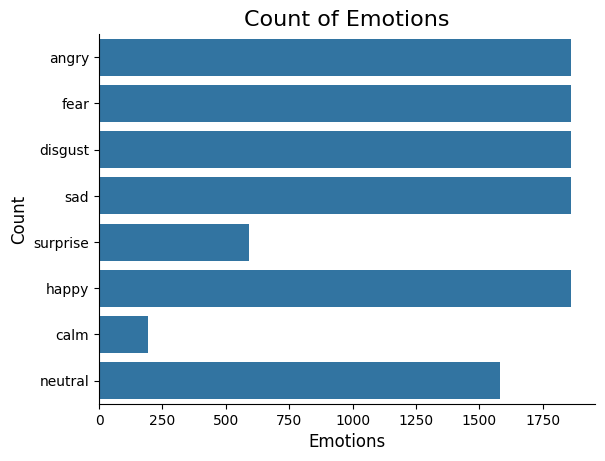

In [14]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

### Data Augmentation
Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.

To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.

The objective is to make our model invariant to those perturbations and enhace its ability to generalize.

In order to this to work adding the perturbations must conserve the same label as the original training sample.

In images data augmention can be performed by shifting the image, zooming, rotating ...

In [15]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data):
    return librosa.effects.time_stretch(data, rate=0.8)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=2)


In [16]:
# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### Simple audio

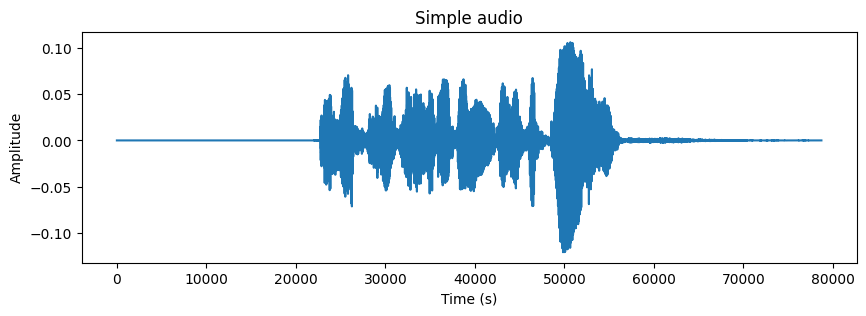

In [17]:
# Plot the waveform using matplotlib
plt.figure(figsize=(10, 3))
plt.plot(data)
plt.title('Simple audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Display audio player
Audio(data, rate=sample_rate)

#### Noise injection

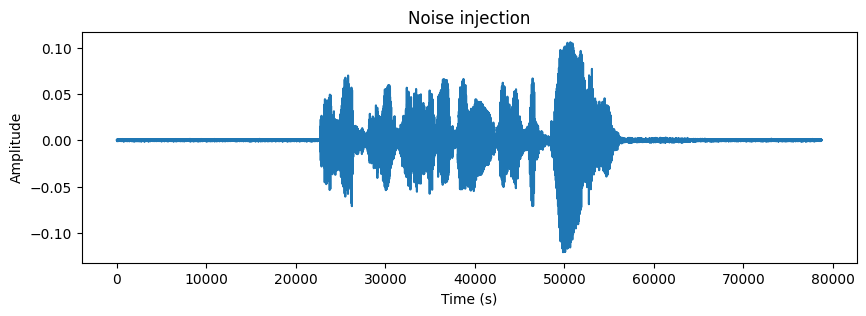

In [18]:
x = noise(data)
plt.figure(figsize=(10, 3))
plt.plot(x)
plt.title('Noise injection')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

Audio(x, rate=sample_rate)

#### Stretching

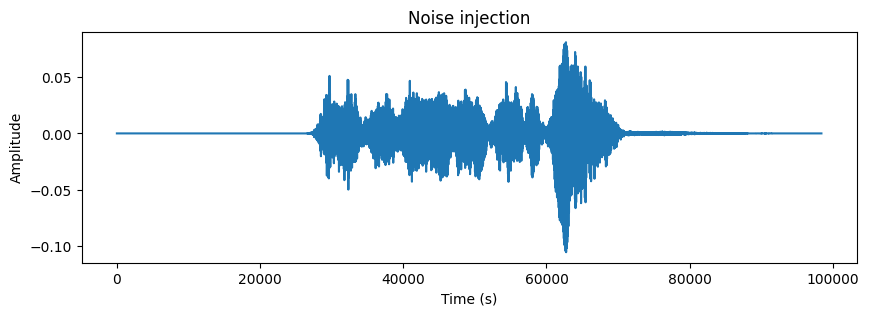

In [19]:
x = stretch(data)
plt.figure(figsize=(10, 3))
plt.plot(x)
plt.title('Noise injection')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

Audio(x, rate=sample_rate)

#### Shifting

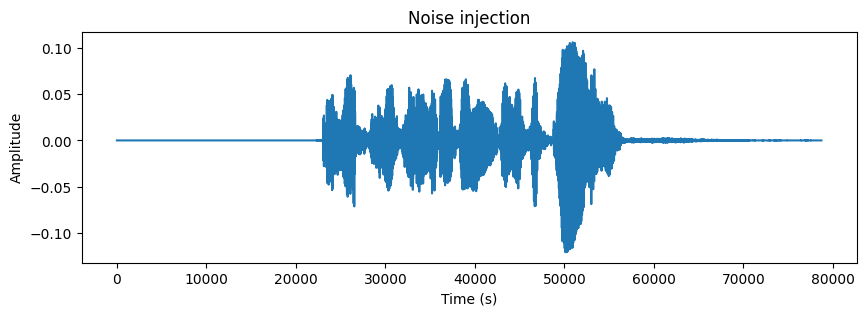

In [20]:
x = shift(data)
plt.figure(figsize=(10, 3))
plt.plot(x)
plt.title('Noise injection')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

Audio(x, rate=sample_rate)

#### Pitching

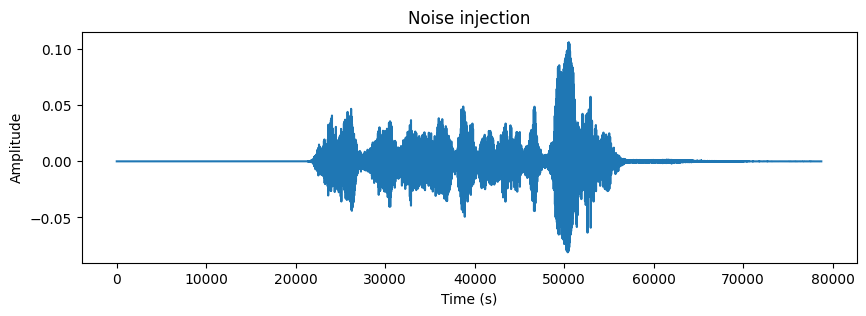

In [21]:
x = pitch(data, sample_rate)
plt.figure(figsize=(10, 3))
plt.plot(x)
plt.title('Noise injection')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

Audio(x, rate=sample_rate)

### Feature Extraction

- Zero Crossing Rate (ZCR)
- Energy
- Spectral Centroid
- Spectral Spread
- Spectral Flux
- Mel-Frequency Cepstral Coefficients (MFCC)
- Chroma Vector

np.hstack is then used to horizontally concatenate these feature vectors into a single, one-dimensional array (result), which becomes the feature representation for that audio file.

In [222]:
def extract_features(data):
    # ZCR (Zero Crossing Rate)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)

    # Energy
    energy = np.mean((librosa.feature.rms(y=data)).T, axis=0)

    # Spectral Centroid
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)

    # Spectral Spread
    spectral_spread = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T, axis=0)

    # Spectral Flux
    spectral_flux = np.mean(librosa.onset.onset_strength(y=data, sr=sample_rate).T, axis=0)

    # MFCC (Mel-Frequency Cepstral Coefficients)
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13).T, axis=0)

    # Chroma Vector
    chroma = np.mean(librosa.feature.chroma_stft(y=data, sr=sample_rate).T, axis=0)

    # Stack all features horizontally
    result = np.hstack((zcr, energy, spectral_centroid, spectral_spread, spectral_flux, mfcc, chroma))
    return result

There is no big difference when we do audio shifting. We are not going to use it.

In [210]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start 
    # and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [213]:

def get_features_simple(path):
    # duration and offset are used to take care of the no audio in start 
    # and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    result = extract_features(data)
    
    return result
    

#### extract features with data augmentation

In [130]:
data_path

,Emotions,Path
0,angry,data_SIAKE/audio_speech_actors_01-24/Actor_16/...
1,fear,data_SIAKE/audio_speech_actors_01-24/Actor_16/...
2,fear,data_SIAKE/audio_speech_actors_01-24/Actor_16/...
3,angry,data_SIAKE/audio_speech_actors_01-24/Actor_16/...
4,disgust,data_SIAKE/audio_speech_actors_01-24/Actor_16/...
...,...,...
2795,sad,data_SIAKE/TESS Toronto emotional speech set d...
2796,sad,data_SIAKE/TESS Toronto emotional speech set d...
2797,sad,data_SIAKE/TESS Toronto emotional speech set d...
2798,sad,data_SIAKE/TESS Toronto emotional speech set d...


In [168]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

/Users/siakesophie/Local_Docs/ING_3/S9/Engineering_project/project/SERAPP/.env-serapp/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [ ]:
len(X), len(Y), data_path.Path.shape

#### Extract features without data augmentation.

In [202]:
# List of feature names
feature_names = [
    'ZCR', 'Energy', 'SpectralCentroid', 'SpectralSpread', 'SpectralFlux',
    'MFCC1', 'MFCC2', 'MFCC3', 'MFCC4', 'MFCC5', 'MFCC6', 'MFCC7',
    'MFCC8', 'MFCC9', 'MFCC10', 'MFCC11', 'MFCC12', 'MFCC13',
    'Chroma1', 'Chroma2', 'Chroma3', 'Chroma4', 'Chroma5', 'Chroma6',
    'Chroma7', 'Chroma8', 'Chroma9', 'Chroma10', 'Chroma11', 'Chroma12'
]


In [223]:
X_simple, Y_simple = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features_simple(path)
    X_simple.append(feature)
    Y_simple.append(emotion)

/Users/siakesophie/Local_Docs/ING_3/S9/Engineering_project/project/SERAPP/.env-serapp/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [224]:
len(X_simple), len(Y_simple), data_path.Path.shape

(11682, 11682, (11682,))

### Création du dataset

#### With Data augmentation

In [170]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,labels
0,0.204540,0.018793,3157.236579,2216.501199,2.351883,-440.286591,52.299297,-6.665863,4.278304,-15.808314,...,0.321975,0.346781,0.480067,0.331558,0.274953,0.354453,0.393035,0.393787,0.369280,angry
1,0.362345,0.022387,4819.179568,3160.589138,1.248035,-229.394710,12.821296,3.215798,-0.741651,-4.549617,...,0.482356,0.549184,0.466870,0.414385,0.493070,0.551853,0.545935,0.539208,0.497893,angry
2,0.230451,0.008324,3406.733059,2340.013524,1.496660,-491.448151,47.446922,-12.718010,-4.566107,-22.940006,...,0.209843,0.225962,0.267457,0.327613,0.502695,0.313019,0.257691,0.319452,0.360415,angry
3,0.189815,0.012744,2744.419931,1984.251392,1.925617,-484.020691,52.436253,-8.613789,6.417563,-3.227553,...,0.285417,0.207637,0.242176,0.227869,0.242703,0.299185,0.388764,0.382405,0.378763,fear
4,0.276914,0.012955,3887.695084,2747.431654,1.664774,-410.314343,32.671547,2.355471,1.516048,-1.694319,...,0.455472,0.427006,0.393767,0.370885,0.373850,0.436515,0.492818,0.488235,0.507414,fear


In [24]:
df_features = pd.read_csv('features.csv')
X = df_features.drop(['labels'], axis=1)
Y = df_features['labels']

In [25]:
Y = np.array(Y)
X = np.array(X)

In [26]:
X.shape, Y.shape

((35046, 30), (35046,))

#### Without data augmentation

In [225]:
Features_simple = pd.DataFrame(X_simple, columns=feature_names)
Features_simple['labels'] = Y_simple
Features_simple.to_csv('features_simple.csv', index=False)
Features_simple.head()

,ZCR,Energy,SpectralCentroid,SpectralSpread,SpectralFlux,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,...,Chroma4,Chroma5,Chroma6,Chroma7,Chroma8,Chroma9,Chroma10,Chroma11,Chroma12,labels
0,0.204540,0.018793,3157.236579,2216.501199,2.351883,-440.286591,52.299297,-6.665863,4.278304,-15.808314,...,0.321975,0.346781,0.480067,0.331558,0.274953,0.354453,0.393035,0.393787,0.369280,angry
1,0.189815,0.012744,2744.419931,1984.251392,1.925617,-484.020691,52.436253,-8.613789,6.417563,-3.227553,...,0.285417,0.207637,0.242176,0.227869,0.242703,0.299185,0.388764,0.382405,0.378763,fear
2,0.200589,0.061085,3130.434636,2301.913172,2.341648,-315.505432,27.667685,-38.753201,0.213876,-14.901350,...,0.237158,0.168251,0.235008,0.320012,0.395711,0.443678,0.420142,0.433307,0.439407,fear
3,0.177156,0.040083,2874.637946,2220.399237,2.429970,-346.149780,52.521111,-14.139482,6.766320,-16.968788,...,0.367692,0.330350,0.368875,0.278672,0.218055,0.257016,0.376277,0.342528,0.312693,angry
4,0.175203,0.006512,2897.465696,2159.335761,2.339541,-532.369385,70.741547,-1.425078,11.303340,-9.632647,...,0.345111,0.322321,0.372758,0.350202,0.387294,0.438436,0.350818,0.331767,0.371133,disgust


In [226]:
Features_simple.shape

(11682, 31)

In [227]:
df_features_simple = pd.read_csv('features_simple.csv')
X_simple = df_features_simple.drop(['labels'], axis=1)
Y_simple = df_features_simple['labels']

In [228]:
Y_simple = np.array(Y_simple)
X_simple = np.array(X_simple)

In [229]:
X_simple.shape, Y_simple.shape

((11682, 30), (11682,))

In [233]:
np.min(X_simple)

-1131.3707275390625

In [234]:
np.min(X_simple), np.max(X_simple)

(-1131.3707275390625, 4990.732365133476)

#### Data Split

In [141]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_simple)

In [235]:
from sklearn.preprocessing import MinMaxScaler

# Reshape X_simple if needed (MinMaxScaler expects 2D array)
X_simple_reshaped = X_simple.reshape(-1, 1)

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
X_scaled = scaler.fit_transform(X_simple_reshaped)

In [236]:
np.min(X_scaled), np.max(X_scaled)

(0.0, 0.9999999999999999)

In [237]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X_simple, Y_simple, random_state=42, test_size=0.2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((9345, 30), (9345,), (2337, 30), (2337,))

In [238]:
y_train

array(['neutral', 'sad', 'angry', ..., 'sad', 'sad', 'disgust'],
      dtype=object)

In [30]:
# Update labels for binary classification because we are classifying only anger
y_train_binary = np.where(y_train == 'anger', 1, 0)
y_test_binary = np.where(y_test == 'anger', 1, 0)


In [239]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns



#### Model Training

In [276]:

from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.layers import Dropout, BatchNormalization


def cnn_train_model(num_classes, input_features):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(input_features,)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  # Use 'softmax' for multi-class classification
    
    return model

def svm_train_model(X_train, y_train):
    # Train a Support Vector Machine (SVM) model
    svm_model = SVC(kernel='linear', C=1)
    svm_model.fit(X_train, y_train)
    
    return svm_model

def train_model_knn(X_train, y_train):
    model = KNeighborsClassifier()
    param_grid = {'n_neighbors': [1, 3, 5, 7, 9]}
    grid_search = GridSearchCV(model, param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    best_knn = grid_search.best_estimator_

    return best_knn

In [241]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_cnn_model(model, X_test, y_test, label_encoder):
   # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test Loss: {loss:.4f}')
    print(f'Test Accuracy: {accuracy:.4f}')

    # Predictions
    y_pred = model.predict(X_test)

    # Decode labels
    y_test_decoded = label_encoder.inverse_transform(y_test)
    y_pred_decoded = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test_decoded, y_pred_decoded))

    # Confusion Matrix
    cm = confusion_matrix(y_test_decoded, y_pred_decoded)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


In [242]:
def evaluate_cnn_model_overfitting(loaded_history=None):
    
    if loaded_history:
        # Plot training & validation loss values
        plt.subplot(1, 2, 1)
        plt.plot(loaded_history['loss'])
        plt.plot(loaded_history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        # Plot training & validation accuracy values
        plt.subplot(1, 2, 2)
        plt.plot(loaded_history['accuracy'])
        plt.plot(loaded_history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.tight_layout()
        plt.show()


In [243]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

In [244]:
X_train.shape

(9345, 30)

In [268]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

#save label encoder
joblib.dump(label_encoder, 'models_SIAKE/label_encoder.pkl')

['models_SIAKE/label_encoder.pkl']

#### KNN Model

In [259]:
knn_model = train_model_knn(X_train, y_train_encoded)


In [260]:
evaluate_model(knn_model, X_test, y_test_encoded)

Accuracy: 0.3684
Precision: 0.3629
Recall: 0.3684


#### CNN Model

In [277]:
input_features = X_train.shape[1]
num_classes = 8

cnn_model = cnn_train_model(num_classes, input_features)

In [294]:
num_epochs = 20
learning_rate = 0.0001
batch_size = 60

In [295]:
import keras
sgd = keras.optimizers.legacy.SGD(learning_rate = learning_rate)
adam = keras.optimizers.legacy.Adam(learning_rate=learning_rate)
#optimizer = keras.optimizers.legacy.Adagrad(learning_rate=learning_rate)

# Compile the model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [296]:
cnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 128)               3968      
                                                                 
 batch_normalization_7 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 dense_21 (Dense)            (None, 8)                 520       
                                                                 
Total params: 13256 (51.78 KB)
Trainable params: 13000 (50.78 KB)
Non-trainable params: 256 (1.00 KB)
__________________

In [292]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=0)

In [297]:
# Train the model with callbacks
history = cnn_model.fit(X_train, y_train_encoded, epochs=num_epochs, batch_size=batch_size,
                                  validation_data=(X_test, y_test_encoded), verbose=2, callbacks=[early_stopping, model_checkpoint])


Epoch 1/20
156/156 - 1s - loss: 1.2664 - accuracy: 0.4934 - val_loss: 1.1635 - val_accuracy: 0.5460 - 552ms/epoch - 4ms/step
Epoch 2/20
156/156 - 0s - loss: 1.2741 - accuracy: 0.4871 - val_loss: 1.2094 - val_accuracy: 0.5190 - 132ms/epoch - 843us/step
Epoch 3/20
156/156 - 0s - loss: 1.2726 - accuracy: 0.4922 - val_loss: 1.2567 - val_accuracy: 0.4831 - 126ms/epoch - 808us/step
Epoch 4/20
156/156 - 0s - loss: 1.2679 - accuracy: 0.4904 - val_loss: 1.1772 - val_accuracy: 0.5315 - 127ms/epoch - 813us/step
Epoch 5/20
156/156 - 0s - loss: 1.2575 - accuracy: 0.4944 - val_loss: 1.2357 - val_accuracy: 0.5058 - 124ms/epoch - 792us/step
Epoch 6/20
156/156 - 0s - loss: 1.2667 - accuracy: 0.4889 - val_loss: 1.2247 - val_accuracy: 0.5113 - 124ms/epoch - 795us/step
Epoch 7/20
156/156 - 0s - loss: 1.2590 - accuracy: 0.4989 - val_loss: 1.2410 - val_accuracy: 0.4955 - 123ms/epoch - 791us/step
Epoch 8/20
156/156 - 0s - loss: 1.2630 - accuracy: 0.4976 - val_loss: 1.2044 - val_accuracy: 0.5049 - 124ms/epoch

In [298]:
# Save the model
cnn_model.save('best_model.h5')

# Save the training history
import pickle
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Test Loss: 1.1829
Test Accuracy: 0.5357
74/74 [==============================] - 0s 348us/step
Classification Report:
              precision    recall  f1-score   support

       angry       0.70      0.65      0.67       386
        calm       0.33      0.94      0.49        35
     disgust       0.59      0.40      0.47       382
        fear       0.75      0.20      0.31       386
       happy       0.45      0.63      0.52       388
     neutral       0.42      0.57      0.48       281
         sad       0.57      0.73      0.64       364
    surprise       0.59      0.59      0.59       115

    accuracy                           0.54      2337
   macro avg       0.55      0.59      0.52      2337
weighted avg       0.58      0.54      0.52      2337



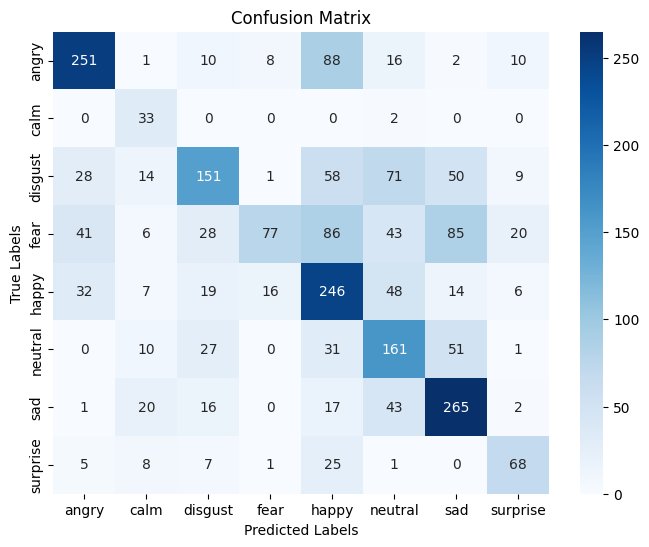

In [299]:
from keras.models import load_model

# Load the model
loaded_model = load_model('best_model.h5')

# Assuming you have X_test, y_test, and label_encoder
evaluate_cnn_model(loaded_model, X_test, y_test_encoded, label_encoder)


In [300]:
# Load the training history
with open('training_history.pkl', 'rb') as f:
    loaded_history = pickle.load(f)


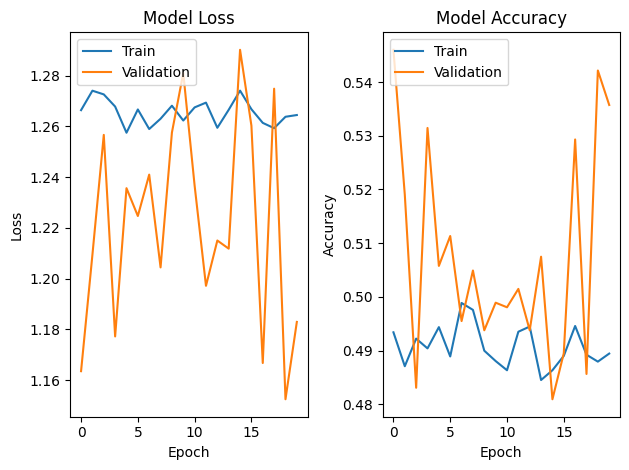

In [301]:
evaluate_cnn_model_overfitting(loaded_history)

### Predictions

In [302]:
# Make predictions
predictions = loaded_model.predict(X_test)

# Get the index of the maximum probability in each prediction
predicted_labels = np.argmax(predictions, axis=1)

# Convert predictions to binary labels
#predicted_labels_binary = np.round(predictions_binary).flatten()

# Decode the predicted labels using the label encoder
predicted_emotions = label_encoder.inverse_transform(predicted_labels)




74/74 [==============================] - 0s 385us/step


In [303]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = predicted_emotions
df['Actual Labels'] = y_test

df.head(10)

,Predicted Labels,Actual Labels
0,surprise,surprise
1,sad,sad
2,calm,calm
3,calm,calm
4,happy,angry
5,sad,neutral
6,surprise,surprise
7,happy,happy
8,disgust,happy
9,disgust,disgust


In [304]:
np.sum(df['Predicted Labels']== df['Actual Labels']), len(df)

(1252, 2337)

### Saving models

In [305]:
# Sauvegarde des modeles
print("🔄 Models saving ...")
joblib.dump(loaded_model, 'models_SIAKE/cnn_model.pkl')
print("✅ Models saved successfully !")

🔄 Models saving ...
✅ Models saved successfully !


### Test of models

In [306]:
# Chargement des modeles
loaded_cnn_model = joblib.load('models_SIAKE/cnn_model.pkl')

In [307]:
# Later, to load the label encoder
loaded_label_encoder = joblib.load('models_SIAKE/label_encoder.pkl')

In [308]:
def predict_emotion(model, label_encoder, audio_test_file):
    data, sample_rate = librosa.load(audio_test_file, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1).reshape(1, -1)
    res = scaler.fit_transform(result)
        
    # Make prediction using the provided model
    prediction = model.predict(res)

    # Get the index of the emotion with the highest probability
    max_prob_index = np.argmax(prediction, axis=1)

    # Decode the predicted label using the label encoder
    predicted_emotion = label_encoder.inverse_transform(max_prob_index)

    print("Audio File is anger: ", audio_test_file)
    print("CNN Prediction: ", predicted_emotion)
    
    return predict_emotion


In [309]:
audio_file = "test_data/Savee_audios/KL_a04.wav"

predicted_emotions = predict_emotion(loaded_model, loaded_label_encoder, audio_file)

1/1 [==============================] - 0s 94ms/step
Audio File is anger:  test_data/Savee_audios/KL_a04.wav
CNN Prediction:  ['angry']


In [311]:
def safe_inverse_transform(label_encoder, y):
    # Get the set difference between y and the known classes
    diff = set(y) - set(label_encoder.classes_)

    # If there are unseen labels, replace them with a default label or handle as needed
    if diff:
        print(f"Unseen labels: {diff}")
        y = [label if label in label_encoder.classes_ else 'unknown_label' for label in y]

    # Inverse transform
    return label_encoder.inverse_transform(y)

In [352]:
def get_true_label(file_path):
    label_mapping = {
        'a': 'angry',
        'c': 'calm',
        'd': 'disgust',
        'f': 'fear',
        'h': 'happy',
        'n': 'neutral',
        'sa': 'sad',
        'su': 'surprise'
    }

    # Extract the first letter after the underscore
    file_name = os.path.basename(file_path)
    parts = file_name.split('.')[0]
    part = parts.split('_')[1]
    
    letters = [char.lower() for char in part if char.isalpha()]
    label = ''.join(letters)
    
    # Get the corresponding label from the mapping
    true_label = label_mapping[label]

    return true_label

In [353]:
file_path = "test_data/Savee_audios/DC_a01.wav"
get_true_label(file_path)

'angry'

In [354]:
def predict_emotions_in_directory(model, label_encoder, directory_path):
    audio_files = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if file.endswith('.wav')]
        
    predictions = []
    probabilities = []

    correct_predictions = 0
    incorrect_predictions = 0

    for audio_file in audio_files:
        data, sample_rate = librosa.load(audio_file, duration=2.5, offset=0.6)
        
        # without augmentation
        res1 = extract_features(data)
        result = np.array(res1).reshape(1, -1)
        res = scaler.fit_transform(result)
            
        # Make prediction using the provided model
        prediction = model.predict(res)

        # Get the index of the emotion with the highest probability
        max_prob_index = np.argmax(prediction, axis=1)

        # Decode the predicted label using the label encoder
        predicted_emotion = label_encoder.inverse_transform(max_prob_index)
        
        true_label = get_true_label(audio_file)
        
        # Check if the prediction is correct
        if predicted_emotion == true_label:
            correct_predictions += 1
        else:
            incorrect_predictions += 1

        # Get the probability of the predicted label
        predicted_probability = np.max(prediction)

        predictions.append(predicted_emotion)
        probabilities.append(predicted_probability)

    total_predictions = len(audio_files)
    print(f"\nTotal Predictions: {total_predictions}")
    print(f"Correct Predictions: {correct_predictions}")
    print(f"Incorrect Predictions: {incorrect_predictions}")
        
    return audio_files, predictions, probabilities 

In [350]:
directory_path = "test_data/Savee_audios"

In [355]:
audio_files, predicted_labels, predicted_probabilities = predict_emotions_in_directory(loaded_cnn_model, loaded_label_encoder, directory_path)

1/1 [==============================] - 0s 28ms/step

Total Predictions: 480
Correct Predictions: 60
Incorrect Predictions: 420


In [356]:
predicted_labels, predicted_probabilities

([array(['angry'], dtype=object),
  array(['angry'], dtype=object),
  array(['angry'], dtype=object),
  array(['angry'], dtype=object),
  array(['angry'], dtype=object),
  array(['angry'], dtype=object),
  array(['angry'], dtype=object),
  array(['angry'], dtype=object),
  array(['angry'], dtype=object),
  array(['angry'], dtype=object),
  array(['angry'], dtype=object),
  array(['angry'], dtype=object),
  array(['angry'], dtype=object),
  array(['angry'], dtype=object),
  array(['angry'], dtype=object),
  array(['angry'], dtype=object),
  array(['angry'], dtype=object),
  array(['angry'], dtype=object),
  array(['angry'], dtype=object),
  array(['angry'], dtype=object),
  array(['angry'], dtype=object),
  array(['angry'], dtype=object),
  array(['angry'], dtype=object),
  array(['angry'], dtype=object),
  array(['angry'], dtype=object),
  array(['angry'], dtype=object),
  array(['angry'], dtype=object),
  array(['angry'], dtype=object),
  array(['angry'], dtype=object),
  array(['angr